<a href="https://colab.research.google.com/github/ishaan10dutta/Time-Series-Forecasting-Analysis-Ensemble-in-Python/blob/master/LSTMs_stock_price_movements.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##LSTMs for Time Series Forecasting

As per my previous notebook, where I used statistical models like ARIMA, as well as Fourier Transform, both of which performed well in their predictions.

However, for the vanilla LSTM network for 1 feature and 5 features, the model performed poorly, and relied on the Stock OHLC values.

I decided to predict the stock price movements, rather than simply plugging in the stock prices.

The plan is to normalize only the closing prices and then break it into train and test datasets. 

I will keep a simple lookback window to give all similar data same movement(movement is just giving the data points the same kind of normalization) and put them in price points as input.

##Setting up

In [1]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [12]:
link = 'https://drive.google.com/open?id=1Qq9A3hV-x7D4R9lDG178_z0VeEj7c9Gi'
fluff, id = link.split('=')

import numpy as np
import pandas as pd
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('AMZN.csv')

##Loading the dataset

In [22]:
import datetime
def parser(x):
    return datetime.datetime.strptime(x,'%m/%d/%Y')

data = pd.read_csv("AMZN.csv", header=0, parse_dates=[0], date_parser=parser)

In [23]:
data.head(5)

,Date,Open,High,Low,Adj Close,Volume,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,Fourier,ARIMA,Close,labels
0,2010-01-04,136.250000,136.610001,133.139999,133.899994,7599900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,133.899994,NaN
1,2010-01-05,133.429993,135.479996,131.809998,134.690002,8851900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,134.690002,NaN
2,2010-01-06,134.600006,134.729996,131.649994,132.250000,7178800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,132.250000,NaN
3,2010-01-07,132.009995,132.320007,128.800003,130.000000,11030200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,130.000000,NaN
4,2010-01-08,130.559998,133.679993,129.029999,133.520004,9830500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,133.520004,NaN


In [24]:
data.describe()

,Open,High,Low,Adj Close,Volume,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,Fourier,ARIMA,Close,labels
count,2265.000000,2265.000000,2265.000000,2265.000000,2.265000e+03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2265.000000,0.0
mean,553.000949,558.568702,546.430821,552.743179,4.603646e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,552.743179,NaN
std,470.155920,474.660681,463.993737,469.357785,2.954860e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,469.357785,NaN
min,105.930000,111.290001,105.800003,108.610001,9.844000e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,108.610001,NaN
25%,217.649994,219.979996,214.460007,217.830002,2.786500e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,217.830002,NaN
50%,334.679993,336.760010,328.940002,332.910004,3.872500e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,332.910004,NaN
75%,766.599976,771.219971,761.200012,767.330017,5.425000e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,767.330017,NaN
max,2038.109985,2050.500000,2013.000000,2039.510010,4.242110e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2039.510010,NaN


In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2265 entries, 0 to 2264
Data columns (total 20 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        2265 non-null   datetime64[ns]
 1   Open        2265 non-null   float64       
 2   High        2265 non-null   float64       
 3   Low         2265 non-null   float64       
 4   Adj Close   2265 non-null   float64       
 5   Volume      2265 non-null   int64         
 6   ma7         0 non-null      float64       
 7   ma21        0 non-null      float64       
 8   26ema       0 non-null      float64       
 9   12ema       0 non-null      float64       
 10  MACD        0 non-null      float64       
 11  20sd        0 non-null      float64       
 12  upper_band  0 non-null      float64       
 13  lower_band  0 non-null      float64       
 14  ema         0 non-null      float64       
 15  momentum    0 non-null      float64       
 16  Fourier     0 non-null  

##Data Preprocessing

In [26]:
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import time

In [27]:
data = data.dropna(axis = "columns")

In [28]:
data.head(5)

,Date,Open,High,Low,Adj Close,Volume,Close
0,2010-01-04,136.250000,136.610001,133.139999,133.899994,7599900,133.899994
1,2010-01-05,133.429993,135.479996,131.809998,134.690002,8851900,134.690002
2,2010-01-06,134.600006,134.729996,131.649994,132.250000,7178800,132.250000
3,2010-01-07,132.009995,132.320007,128.800003,130.000000,11030200,130.000000
4,2010-01-08,130.559998,133.679993,129.029999,133.520004,9830500,133.520004


In [29]:
data_close = data['Close']

In [30]:
data_close.shape

(2265,)

In [31]:
data_close = data_close.values.reshape(2265,1)

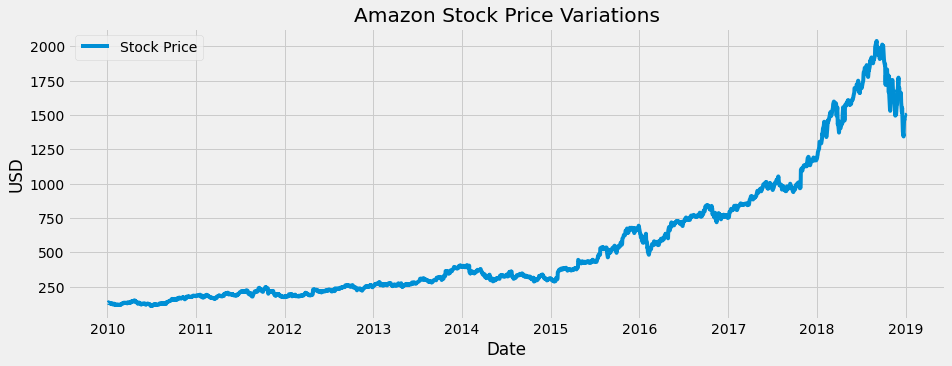

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
from sklearn.preprocessing import MinMaxScaler

plt.figure(figsize=(14, 5))
plt.plot(data['Date'], data['Close'], label='Stock Price')
plt.xlabel('Date')
plt.ylabel('USD')
plt.title('Amazon Stock Price Variations')
plt.legend(loc='best')
plt.show()

scaler = MinMaxScaler(feature_range=(0, 1))
data_close = scaler.fit_transform(data_close)

In [36]:
#Training and testing data split
train_size = int(len(data_close) * 0.80)
test_size = len(data_close) - train_size
train, test = data_close[0:train_size,:], data_close[train_size:len(data_close),:]
print('Number of training samples:', len(train)) 
print('Number of testing samples:', len(test))

Number of training samples: 1812
Number of testing samples: 453


##Normalization 

I will be normalizing the price data, so that they are reduced to normalized values, and it will be helpful in calculating stock price movements.

In [37]:
#converting an array of values into a dataset matrix
def create_dataset(dataset, look_back=1): #keeping only similar values, and jumping to the next value if values are too far apart
	dataX, dataY = [], []  
	for i in range(len(dataset)-look_back-1): #dataY holds only output values
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [38]:
#reshaping into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [39]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

#Building and compiling the model

In [46]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Flatten

model = Sequential()
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(units = 1))
model.add(Activation('relu'))
model.compile(optimizer = 'rmsprop', loss = 'mean_squared_error', metrics = ['mean_absolute_error'])

In [49]:
model.fit(
    trainX,
    trainY,
    batch_size=128,
    epochs=40,
    validation_split=0.05)

Epoch 1/40
14/14 [==============================] - 0s 10ms/step - loss: 1.2005e-04 - mean_absolute_error: 0.0082 - val_loss: 2.6830e-05 - val_mean_absolute_error: 0.0037
Epoch 2/40
14/14 [==============================] - 0s 7ms/step - loss: 1.3437e-04 - mean_absolute_error: 0.0085 - val_loss: 3.6171e-05 - val_mean_absolute_error: 0.0047
Epoch 3/40
14/14 [==============================] - 0s 7ms/step - loss: 1.1788e-04 - mean_absolute_error: 0.0079 - val_loss: 7.1534e-05 - val_mean_absolute_error: 0.0074
Epoch 4/40
14/14 [==============================] - 0s 8ms/step - loss: 1.1745e-04 - mean_absolute_error: 0.0079 - val_loss: 2.6708e-05 - val_mean_absolute_error: 0.0037
Epoch 5/40
14/14 [==============================] - 0s 9ms/step - loss: 1.1608e-04 - mean_absolute_error: 0.0080 - val_loss: 3.2848e-05 - val_mean_absolute_error: 0.0044
Epoch 6/40
14/14 [==============================] - 0s 8ms/step - loss: 1.2433e-04 - mean_absolute_error: 0.0082 - val_loss: 6.1140e-05 - val_mean_ab

We obtain a MAE of 0.0072 and a validation MAE of 0.0153

#Final Predictions and Evaluation

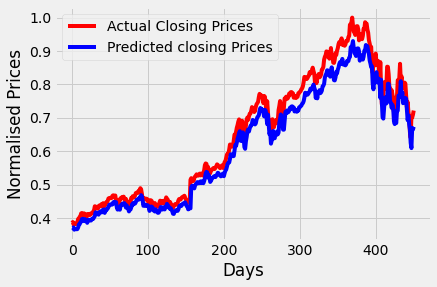

In [50]:
import matplotlib.pyplot as plt
predicted_stateful = model.predict(testX)
plt.plot(testY, color = 'red',label = 'Actual Closing Prices')
plt.plot(predicted_stateful.flatten(), color = 'blue', label  = 'Predicted closing Prices')
plt.xlabel('Days')
plt.ylabel('Normalised Prices')
plt.legend(loc='best')
plt.show()

In [51]:
mae = model.evaluate(trainX,
    trainY,
    batch_size=128,verbose=1)

15/15 [==============================] - 0s 3ms/step - loss: 9.8897e-05 - mean_absolute_error: 0.0089


#Conclusion

Clearly, LSTMs work well to predict Closing Prices when we normalize the prices and predict the Stock Price movement, rather than just using OHLC values.

Now further, I will be using LSTMs to p